# Paper: Historical building lifetime in inner cities/ NE Midtbyen area
for NE Midtbyen, final code.

## Imports

In [1]:
#imports

import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

from scipy.optimize import curve_fit

from scipy import integrate

import random

import os

from scipy.stats import weibull_min
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import truncnorm

from scipy.interpolate import splrep, BSpline
from scipy.interpolate import UnivariateSpline

## Hypothesis and study area

 we use the cohort of survivor buildings to estimate the missing data AND we assume that the buildings were rebuilt in max 10 yrs after the fire

Study area:  NE Midtbyen 
 

## Constants

In [2]:
# Constants
#depending on the area, diff dates

debut_date = 1841
end_date = 1845
present_date = 2022
map_date = 1883
prot_date = 1981
assumed_cohort = 1843

# Histogram range bins
range_bins = [1838 + 2*i for i in range(25)]

# Time steps and range
time_steps = np.arange(debut_date, present_date)
x_range = np.linspace(0, 1000000, 1000001)

# Age steps
age_steps = np.arange(0, present_date - debut_date)

# Fit curve range
x_time = np.linspace(1835, 1890,100)

## Extracting data from the ArcGIS attribute tables

Define the path to the table, it had to have been saved as a .csv file in ArcGIS.

(To save as a .csv file in ArcGIS : Open attribute table >> export >> chose the folder and save as name.csv)

### Functions

In [3]:
# Loading data
current_directory = os.getcwd()


# hypothesis c: we use the cohort of survivor buildings to estimate the missing data 
# AND we assume that the buildings were rebuilt in max 10 yrs after the fire
part_path_demolished = "\data\data_midtbyen\demolished.csv"
part_path_standing = "\data\data_midtbyen\still_standing.csv"
part_path_no_date = "\data\data_midtbyen\_no_date_match.csv"

file_path_demolished = (current_directory + part_path_demolished)
file_path_standing = (current_directory + part_path_standing)
file_path_no_data = (current_directory + part_path_no_date)

In [4]:
# function to read the file as a pandas dataframe and fill the NaN cells with 0

def read_file_csv(file):
    df = pd.read_csv(file, sep = ";")
    return df

#returns a dataframe

### Code

#### Extracting the data exported from ArcGIS (three dataframes : one for the demolished buildings and one for the still standing + one for no data)

The names are misleading: some buildings in the file "demolished" are still standing and vice versa. Proper df are made later

In [5]:
# Get file paths based on hypothesis + area choice
# Read the files into pandas dataframes
df_demolished = read_file_csv(file_path_demolished)
df_standing = read_file_csv(file_path_standing)
df_nodata = read_file_csv(file_path_no_data)
    
# Concatenate the dataframes
df_full = pd.concat([df_demolished, df_standing, df_nodata], ignore_index=True)

# Replace missing values in 'Is_demolished' column with -1
df_full['Is_demolished'] = df_full['Is_demolished'].fillna(-1)

# Fill NaN values with 0
df_full = df_full.fillna(0)

# drop those that are out of range == built before the fire (because we assume that apart from those, no buildings survived the fire)

df_full = df_full.drop(df_full[(df_full['Construction_max']< debut_date )].index)

## Attributing a demolition date between D_min and D_max

### Functions

In [6]:
def attribute_d_unif(df):
    # If no data for min demolition date, take the max (usually the construction date of the new building) - 10 years
    df['Demolition_min'] = np.where(df['Demolition_min'] == 0, df['Demolition_max'] - 10, df['Demolition_min'])
    
    # Generate a uniform random demolition date between the min and max values
    df['D_unif'] = np.random.uniform(df['Demolition_min'], df['Demolition_max'])
    df['D_unif'] = np.trunc(df['D_unif']).astype(int)
    
    return df


### Code

In [7]:
# attributing the demolition date
df_full = attribute_d_unif(df_full)

# print it to check it
#display(df_full)

## Fitting a lognormal distribution to the buildings still standing

Using the cohorts of the still standing buildings, we fit a lognormal distribution. This distribution will then be used to assign a construction date to the buildings that currently only have an interval as a construction date. 

### Functions

In [8]:
# attributing a construction date for the buildings still standing randomly between min and max
# takes in input the full dataframe
# returns a df of still standing buildings

def attribute_c_unif(df):
    # Create a copy of the DataFrame for buildings that are still standing
    df_res = df[df['Is_demolished'] == False].copy()
    
    # Generate a uniform random construction date between the min and max values
    df_res['C_unif'] = np.random.uniform(df_res['Construction_min'], df_res['Construction_max'])
    df_res['C_unif'] = np.trunc(df_res['C_unif']).astype(int)
    
    return df_res

"""---------------------------------------------------------------------------------"""
# lognormal survival function : for curve fitting

def lognorm_sf(x, s, loc, scale):
    return lognorm.sf(x, s, loc, scale)

"""---------------------------------------------------------------------------------"""
# find best fit of construction date data (with lognormal fct)
# returns the parameters of the fit

def fit_cohort(df):
    return lognorm.fit(df['C_unif'])

"""---------------------------------------------------------------------------------"""
# find best fit of data, works for any type of fct (not only lognormal)

def fit_surv_fct(s_fct, x, y):
# Fit the data to the lognormal function using curve_fit
    p_surv_fct, p_sf_cov = curve_fit(s_fct, x, y)
    return(p_surv_fct)

### Code

In [9]:
# make a df of still standing buildings (that were built after the fire)

df_still_standing = attribute_c_unif(df_full)

# print dataframe of the buildings still standing
#display(df_still_standing)

# fit the histogram of the construction date using a lognormal function
params_logn = fit_cohort(df_still_standing)

In [10]:
# find out best fit parameters
params_logn = fit_cohort(df_still_standing)

### Plot

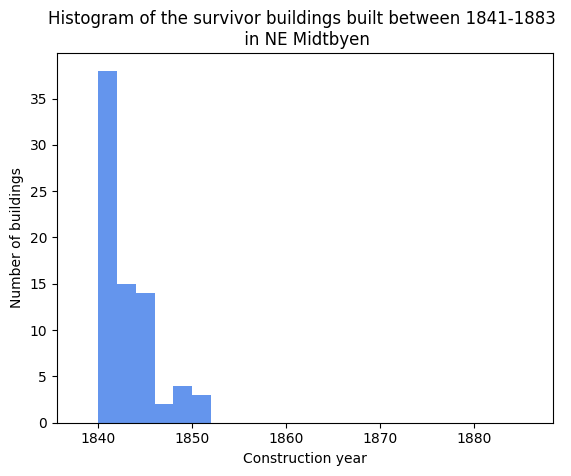

In [11]:
# plot a histogram of the survivor buildings (in 2022)

plt.hist(df_still_standing['C_unif'], bins = range_bins, color='cornflowerblue')
plt.xlabel('Construction year')
plt.ylabel('Number of buildings')
plt.title('Histogram of the survivor buildings built between 1841-1883 \n in NE Midtbyen')

plt.show()

25
(15.082307348659167, 1840.9999999999998, 7.997001789975979e-07)


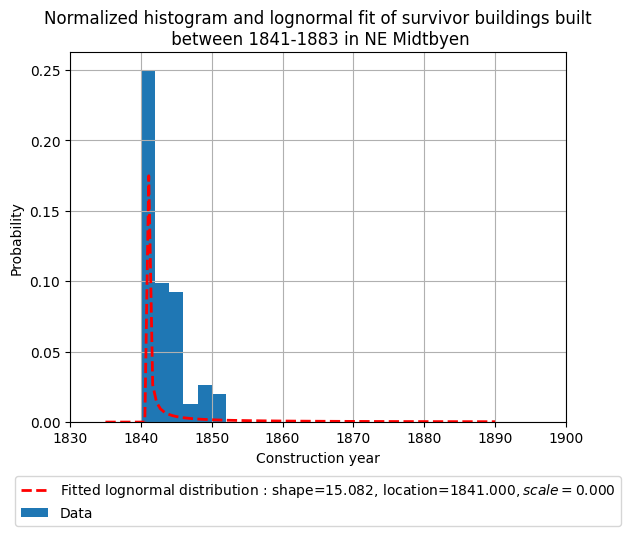

In [12]:
# fit the cohort of still standing buildings

#if midtbyen: use lognorm
# if skansen: weibull works better
params_logn = lognorm.fit(df_still_standing['C_unif'])
n, bins, patches = plt.hist( df_still_standing['C_unif'],bins= range_bins, density=True)
print(len(range_bins))
# add a 'best fit' line
y = lognorm.pdf(x_time, *params_logn)

print(params_logn)
shape = params_logn[0] # shape parameter
loc = params_logn[1] # mean(ln(Y))
scale = params_logn[2] # sd(ln(Y))"""

labels = ['Fitted lognormal distribution : shape=%.3f, location=%.3f$, scale=%.3f$' %(shape,loc,scale),'Data']

plt.plot(x_time , y, 'r--', linewidth=2)
plt.xlabel('Construction year')
plt.ylabel('Probability')
plt.title('Normalized histogram and lognormal fit of survivor buildings built\n between 1841-1883 in NE Midtbyen')
plt.grid(True)
plt.xlim(1830,1900)
plt.legend(labels=labels, loc = 'lower center', bbox_to_anchor=(0.5, -0.3))
#plt.show()

## Attributing a construction date according to the lognormal distribution
To do so, I will create two new columns in the DataFrame : C_unif and D_unif

### Functions

In [13]:
#for the construction date : attribute a value according to the distribution and the interval C_min,C_max
def value_construction(C_min, C_max,params_logn):
    if C_max != C_min:
        rd_lognorm = lognorm.rvs(*params_logn, 1)[0]
        while rd_lognorm > C_max or rd_lognorm < C_min:
            rd_lognorm = lognorm.rvs(*params_logn, 1)[0]
        C_lognorm = int(np.trunc(rd_lognorm))
    else:
        C_lognorm = C_min
    return C_lognorm

#returns one value

"""---------------------------------------------------------------------------------"""
def attribute_c_lognorm(df, params_logn):
    # Generate random variables for construction and demolition dates
    for row in df.iterrows():
        C_max = row[1]['Construction_max']
        C_min = row[1]['Construction_min']
        row[1]['C_lognorm'] = value_construction(C_min, C_max,params_logn)

# doesn't return anything but changes the df



### Code

In [14]:
# creating a working dataframe with only the required data
df_full['C_lognorm'] = 0
df_working = df_full[['Construction_min','Construction_max','C_lognorm']].copy()

# attributing a construction date according to the lognormal fit

attribute_c_lognorm(df_working,params_logn)

# assigning it in the full dataframe as well

df_full['C_lognorm'] = df_working['C_lognorm']

### Plot

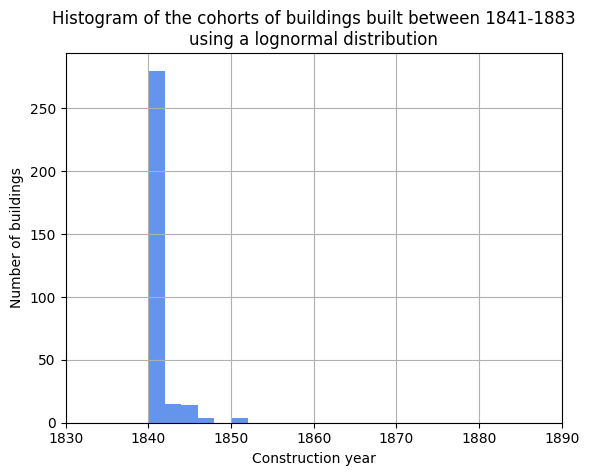

In [15]:
# plotting the histogram of cohort of all buildings (dem + non dem) after attributing construction date using lognormal distribution


plt.hist(df_working['C_lognorm'], bins = range_bins, color ='cornflowerblue')
plt.xlabel('Construction year')
plt.ylabel('Number of buildings')
plt.title('Histogram of the cohorts of buildings built between 1841-1883\nusing a lognormal distribution')
plt.grid(True)
plt.xlim(1830,1890)
plt.show()

[   0 -228   -4   -4   -3    0   -2    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0] [1838 1840 1842 1844 1846 1848 1850 1852 1854 1856 1858 1860 1862 1864
 1866 1868 1870 1872 1874 1876 1878 1880 1882 1884 1886]


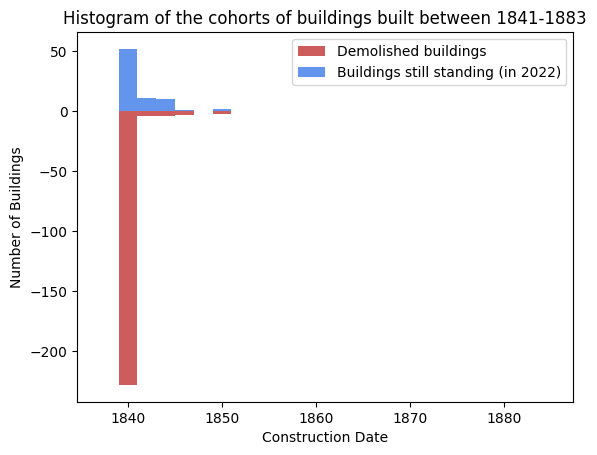

In [16]:
# Differentiating dem and non dem buildings in  a POSITIVE/NEGATIVE HISTOGRAM

# Filter demolished buildings
demolished_df = df_full[df_full['Is_demolished'] == True]

# Filter standing buildings
standing_df = df_full[df_full['Is_demolished'] == False]


negative_data = demolished_df['C_lognorm']
positive_data = standing_df['C_lognorm']
tot_1 = len(negative_data)
tot_2=len(positive_data)
a, b = np.histogram(demolished_df['C_lognorm'],bins=range_bins)
c ,d = np.histogram(standing_df['C_lognorm'],bins=range_bins)
print(-a,b)
fig = plt.figure()
ax = plt.subplot(111)

plt.bar(b[:-1],height=-a,width=np.diff(b), label = 'Demolished buildings', color = 'indianred')
plt.bar(d[:-1],height=c,width=np.diff(d), label = 'Buildings still standing (in 2022)', color = 'cornflowerblue')

plt.xlabel('Construction Date')
plt.ylabel('Number of Buildings')
plt.title('Histogram of the cohorts of buildings built between 1841-1883')

plt.legend()


## Obtaining the Survival function

### Functions

In [17]:
# to obtain the failure time (=> age at demolition)

def failure_time(dem_df,df):
    # Compute the failure time for each demolished building
    age_at_demolition = dem_df['D_unif'] - dem_df['C_lognorm'] 
    # if not demolished: attribute 0, else attribute failure time
    df['Age_at_demolition'] = np.where(df['Is_demolished']==True,df['D_unif']-df['C_lognorm'],0)

# doesnt return anything but changes the df

"""---------------------------------------------------------------------------------"""

#selecting the cohorts of interest ie construction date llies between min and max
def selected_cohorts(df,yr_min,yr_max):
    df_selected_cohort = df[(df['C_lognorm'] >= yr_min) & (df['C_lognorm'] <= yr_max)]
    return df_selected_cohort

#returns a df of the selected cohorts

"""---------------------------------------------------------------------------------"""
#Calculate the points of the survival curve USING AGE

def survival_curve(age, df):
    survival_prob = np.ones(len(age))
    n_total = len(df)
    n_alive = np.sum(df['Is_demolished'] == False)
    for t in (age):
        if t == 0:
            survival_prob[t] = 1

        else: 
            n_survived = np.sum((df['Age_at_demolition'] >= t)) + n_alive
            surv_ratio = n_survived/n_total
            survival_prob[t] = survival_prob[t]*surv_ratio
    return survival_prob

#returns a list (or array ?) of the points of the survival curve 

### Code

In [18]:
# creating a new column in the df to show the age at dmeolition = failure time
failure_time(demolished_df, df_full)

# select the cohorts of interest : here btw 1840-1845
df_1841_1845 = selected_cohorts(df_full, debut_date, end_date)

# NOT NECESSARY BUT BETTER FOR VISUALISATION: assign the same construction date for all buildings in the selected cohorts. That way,
# you can visualize events like fires better

df_1841_1845 = df_1841_1845.assign(C_lognorm = assumed_cohort)

# calculate the survival probabillity according to age on this cohort
survival_prob = survival_curve(age_steps,df_1841_1845)

### Plot

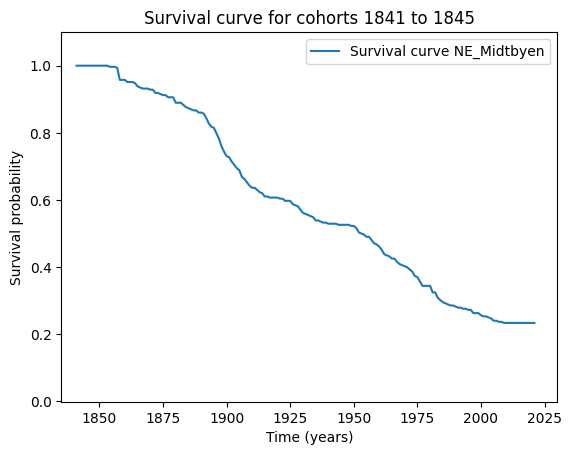

In [19]:
# for cohorts 1841-1845 = estimated as cohort 1843
  
plt.plot(age_steps + debut_date ,survival_prob)
plt.ylim(0,1.1)
plt.xlabel('Time (years)')
plt.ylabel('Survival probability')
plt.title('Survival curve for cohorts 1841 to 1845')
plt.xlim(1835,2030)
plt.ylim(-0.001,1.1)

#labels=['Survival curve NE_Midtbyen']
labels=['Survival curve NE_Midtbyen']
plt.legend(labels=labels)
plt.show()


## Fitting the survival curve and obtaining lifetime

In [20]:
# making a df of all non demolished buildings
df_trace_age = df_full[df_full['Age_at_demolition']>0]

# Constants

x = age_steps
y = survival_prob

### Functions

In [21]:
# Define the Weibull distribution function : use scipy fct directly (offset parameter)
def weibull(x, a, k):
    #return weibull_min.sf(x, c, loc, scale)
    return np.exp(-(x*a)**k) 
"""---------------------------------------------------------------------------------"""
# define normal survival function

def norm_sf(x, loc, scale):
    return norm.sf(x, loc, scale)
"""---------------------------------------------------------------------------------"""
# define lognorm survival function

def lognorm_sf(x, s, loc, scale):
    return lognorm.sf(x, s, loc, scale)

"""---------------------------------------------------------------------------------"""
# def the lifetime functions = pdf

def lifetime_weibull(x, a, k):
    return a*k*(a*x)**(k-1)*np.exp(-(x*a)**k)

def lifetime_norm(x, loc, scale):
    return norm.pdf(x, loc, scale)

def lifetime_lognorm(x, s, loc, scale):
    return lognorm.pdf(x, s, loc, scale)

def lifetime_truncnorm(x,a,b,loc,scale):
    return truncnorm.pdf(x,a,b,loc,scale)
"""---------------------------------------------------------------------------------"""
# define function to obtain R² value = estimate goodness of fit
def calculate_r_squared(actual_values, predicted_values):
    mean_actual = sum(actual_values) / len(actual_values)
    total_sum_of_squares = sum((actual - mean_actual) ** 2 for actual in actual_values)
    residual_sum_of_squares = sum((actual - predicted) ** 2 for actual, predicted in zip(actual_values, predicted_values))
    r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)
    return r_squared

c:\Users\zoec\OneDrive - NTNU\Publication\code_building_lifetimes\.venv\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


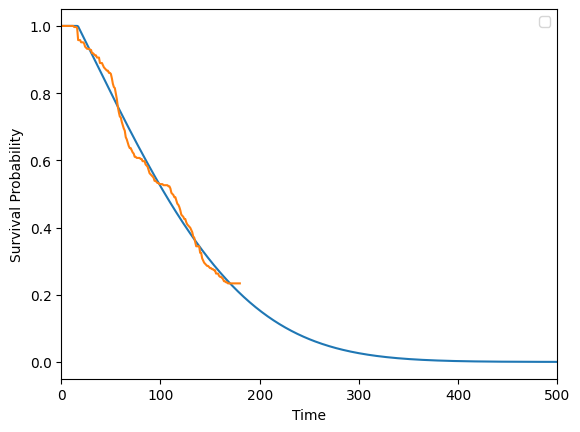

[-9.40918429e-02  1.41285714e+02  2.83746848e+01  1.23547980e+02]
R²_logn = 0.99059906822734


In [22]:
# Define a function for the truncated normal survival function
#def truncated_normal_survival(x, mean, std, a, b):
#    return truncnorm.sf(x, a=(a - mean) / std, b=(b - mean) / std, loc=mean, scale=std)

mean_0, std_0 = 110, 70
a_0 = (10 - mean_0)/std_0
b_0 = (10000 - mean_0)/std_0

p0=[a_0, b_0, mean_0, std_0]

def truncnorm_sf(x,a,b, loc, scale):
    return truncnorm.sf(x,a,b,loc,scale)
# Fit the truncated normal distribution using the defined function
param_truncnorm, cov_truncnorm = curve_fit(truncnorm_sf, x,y,p0)

# Plot the original survival data and the fitted truncated normal distribution
plt.plot(x_range,truncnorm_sf(x_range,*param_truncnorm))
plt.plot(x,y)
plt.legend()
plt.xlim(0,500)
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()
print(param_truncnorm)

r_truncnorm = calculate_r_squared(y,truncnorm_sf(x,*param_truncnorm))
print('R²_logn =',r_truncnorm)

### Code

In [23]:
# Fit the data to the Weibull function using curve_fit
p_weib, p_weib_cov = curve_fit(weibull, x, y)

# Print the fitted parameters
print(p_weib)

# calculate R²
r_weibull = calculate_r_squared(y,weibull(x,*p_weib))
print('R²_weibull =', r_weibull)

[0.00752444 1.55975921]
R²_weibull = 0.9894713303525422


C:\Users\zoec\AppData\Local\Temp\ipykernel_26900\3530553073.py:4: RuntimeWarning: divide by zero encountered in power
  return np.exp(-(x*a)**k)
C:\Users\zoec\AppData\Local\Temp\ipykernel_26900\3530553073.py:4: RuntimeWarning: invalid value encountered in power
  return np.exp(-(x*a)**k)


In [24]:
# Fit the data to the normal function using curve_fit
p_norm, p_norm_cov = curve_fit(norm_sf, x, y)

# Print the fitted parameters
print('mu =', p_norm[0])
print('sigma =', p_norm[1])

r_norm = calculate_r_squared(y,norm_sf(x,*p_norm))
print('R²_normal =', r_norm)

mu = 109.8738804315009
sigma = 69.22863294881041
R²_normal = 0.9684517890989058


In [25]:
# Fit the data to the lognormal function using curve_fit
p_logn, p_logn_cov = curve_fit(lognorm_sf, x, y)

# Print the fitted parameters
print('param =', p_logn)

r_lognorm = calculate_r_squared(y,lognorm_sf(x,*p_logn))
print('R²_lognorm =',r_lognorm)

param = [  0.66421514 -15.03796958 117.49947662]
R²_lognorm = 0.9903646016934843


### Plot

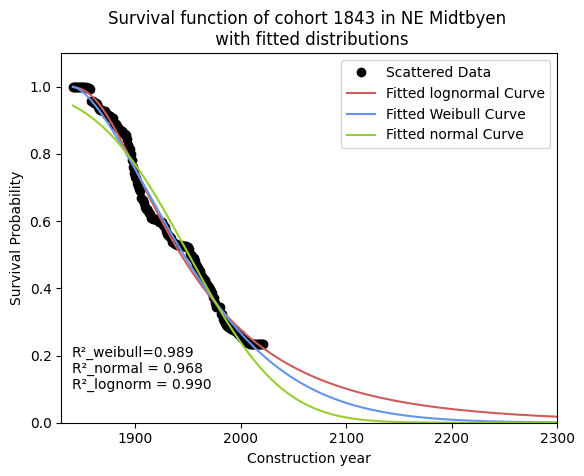

In [26]:
#Trace survival curves with each fit

plt.plot(x+debut_date, y, 'ko', label='Scattered Data')
plt.plot(x_range+debut_date, lognorm_sf(x_range, *p_logn),'indianred', label='Fitted lognormal Curve')
plt.plot(x_range+debut_date, weibull(x_range, *p_weib), 'cornflowerblue', label='Fitted Weibull Curve')
plt.plot(x_range+debut_date, norm_sf(x_range, *p_norm),'yellowgreen', label='Fitted normal Curve')
plt.ylim(0,1.1)
plt.xlabel('Construction year')
plt.ylabel('Survival Probability')
plt.legend()

plt.annotate('R²_weibull=%.3f\nR²_normal = %.3f\nR²_lognorm = %.3f' %(r_weibull,r_norm,r_lognorm), (1840, 0.1))
plt.title('Survival function of cohort 1843 in NE Midtbyen \n with fitted distributions')
plt.xlim(1830,2300)
plt.show()


In [27]:
#Spline function: one lognormal before//another after preservation
i_1981=1981-debut_date
s_before_1981 = survival_prob[0:i_1981]

x_1 = age_steps[0:i_1981]
y_1 = s_before_1981

s_after_1981 = survival_prob[i_1981:]
x_2 = age_steps[i_1981:]

y_2 = s_after_1981

# Fit the data to the lognormal function using curve_fit
p_logn_2, p_logn_cov_2 = curve_fit(lognorm_sf, x_2, y_2)
p_logn_1, p_logn_cov_1 = curve_fit(lognorm_sf, x_1, y_1)


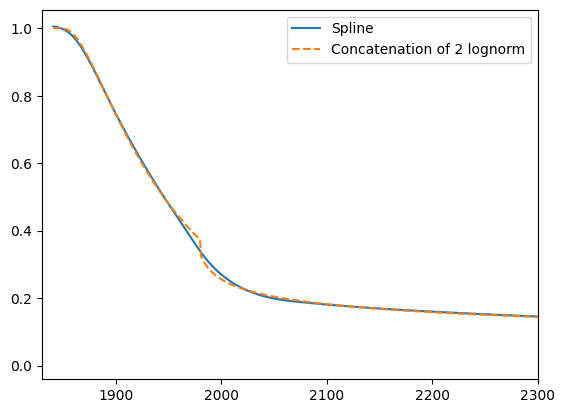

In [29]:
#smooth it with a spline

x_range_array = np.array(x_range)

# Calculate two_lognorm values
two_lognorm_1 = lognorm_sf(x_range_array[x_range_array < i_1981], *p_logn_1)
two_lognorm_2 = lognorm_sf(x_range_array[x_range_array >= i_1981], *p_logn_2)

two_lognorm = np.concatenate((two_lognorm_1, two_lognorm_2))

#adding ones before the beginning so the fit is better
better_fit_x = np.linspace(-10000,-1,10000)
better_fit_y = np.ones(10000)

x_range_spline = np.concatenate((better_fit_x, x_range))
y_range_spline = np.concatenate((better_fit_y, two_lognorm))
spline = UnivariateSpline(x_range_spline,y_range_spline, s=0.025)

plt.plot(x_range+debut_date, spline(x_range))
plt.plot(x_range+debut_date,two_lognorm,'--')

plt.xlim(1830,2300)

label = ['Spline', 'Concatenation of 2 lognorm']
plt.legend(label)

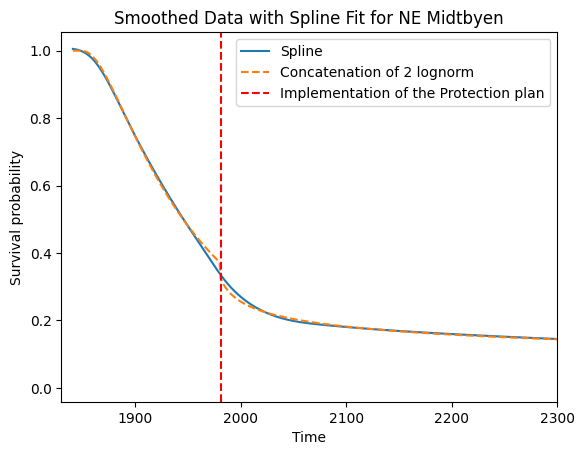

In [38]:
plt.plot(x_range+debut_date, spline(x_range))
plt.plot(x_range+debut_date,two_lognorm,'--')

plt.xlim(1830,2300)

label = ['Spline', 'Concatenation of 2 lognorm','Implementation of the Protection plan']

# Adding title
plt.title('Smoothed Data with Spline Fit for NE Midtbyen')

# Adding x and y axis labels
plt.xlabel('Time')
plt.ylabel('Survival probability')
plt.axvline(x=1981,linestyle='--', color='red')
# Adding legend
plt.legend(label)

# Display the plot
plt.show()

In [62]:
#get the  lifetime distribution: -d(S(t))/dt
diff_survival_probabilities = np.diff(spline(x_range_spline))

# Calculate the derivative of the lifetime distribution
lifetime_distribution_derivative = -diff_survival_probabilities / np.diff(x_range_spline)


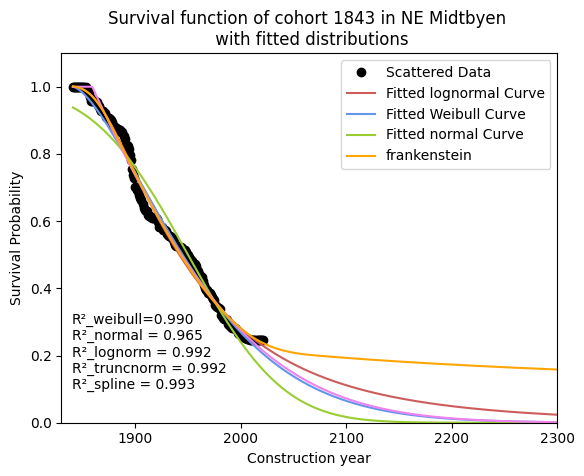

In [64]:
#Trace survival curves with each fit


plt.plot(x+debut_date, y, 'ko', label='Scattered Data')
plt.plot(x_range+debut_date, lognorm_sf(x_range, *p_logn),'indianred', label='Fitted lognormal Curve')
plt.plot(x_range+debut_date, weibull(x_range, *p_weib), 'cornflowerblue', label='Fitted Weibull Curve')
plt.plot(x_range+debut_date, norm_sf(x_range, *p_norm),'yellowgreen', label='Fitted normal Curve')
plt.plot(x_range+debut_date,truncnorm_sf(x_range,*param_truncnorm),'violet')
plt.plot(x_range+debut_date, spline(x_range),'orange',label='frankenstein')

r_frank = calculate_r_squared(y,spline(x))

plt.ylim(0,1.1)
plt.xlabel('Construction year')
plt.ylabel('Survival Probability')
plt.legend()

plt.annotate('R²_weibull=%.3f\nR²_normal = %.3f\nR²_lognorm = %.3f\nR²_truncnorm = %.3f\nR²_spline = %.3f' %(r_weibull,r_norm,r_lognorm,r_truncnorm, r_frank), (1840, 0.1))
plt.title('Survival function of cohort 1843 in NE Midtbyen \n with fitted distributions')
plt.xlim(1830,2300)
plt.show()



Average lifetime with lognorm distrib is 134.64526710542304
Average lifetime with normal distrib is  109.0617025817019


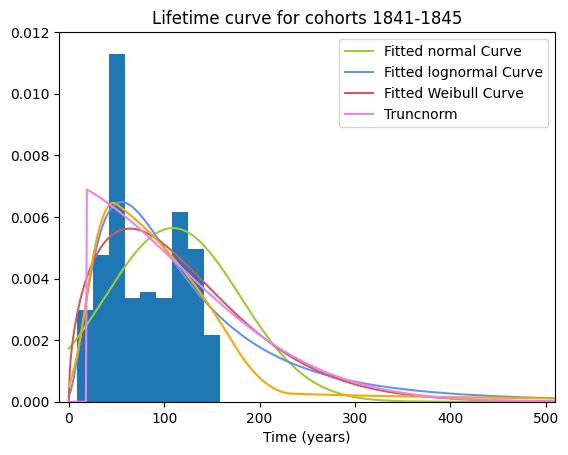

In [65]:
# Plotting the histogram to visualize beneath the lifetime curve. I have to keep it normalized, but take away the still standing bar
df_full = df_full.fillna(0)
tot = len(df_1841_1845)
a, bins_d = np.histogram(df_1841_1845['Age_at_demolition'])
h_histo = a/(tot*np.diff(bins_d)) # HEIGHT OF THE FIRST BAR THAT I WANT TO TAKE OUT
# getting rid of the "still standing buildings" bar
h_histo[0]=0

#plot histogram of data (age at demolition)
plt.bar(bins_d[:-1],height=h_histo,width=np.diff(bins_d), color ='cornflowerblue')

"""---------------------------------------------------------------------------------"""
print("Average lifetime with lognorm distrib is",lognorm.mean(*p_logn))
print( "Average lifetime with normal distrib is ", norm.mean(*p_norm))

# plot lifetimes with all distributions 
plt.plot(x_range,lifetime_norm(x_range, *p_norm),'yellowgreen', label='Fitted normal Curve')
plt.plot(x_range,lifetime_lognorm(x_range, *p_logn),'cornflowerblue', label='Fitted lognormal Curve')
plt.plot(x_range,lifetime_weibull(x_range, *p_weib), 'indianred', label='Fitted Weibull Curve')
plt.plot(x_range[:1000000],lifetime_distribution_derivative[10000:],'orange')
plt.plot(x_range,lifetime_truncnorm(x_range,*param_truncnorm),'violet',label='Truncnorm')
plt.xlabel('Time (years)')
plt.title('Lifetime curve for cohorts 1841-1845')
plt.legend()
plt.xlim(-10,510)
plt.ylim(0,0.012)


plt.bar(bins_d[:-1],height=h_histo,width=np.diff(bins_d))
plt.show()


## Extract back to csv to use on ArcGIS (LEAVE AS COMMENTED)

In [ ]:
"""# specify the output file path
out_file = r"C:\Users\zoec\OneDrive - NTNU\Thesis_NTNU\Datafram_tables\results\result_file_Midtbyen.csv"

# write the dataframe to a csv file
df_full.to_csv(out_file, index=False,sep=';')"""

## Hazard rate 

### With the stock definition
h(t) = -(stock (t+ dt) - stock(t))/stock(t)*dt

In [66]:
# computing the stock of buildings per year (all cohorts ?)

def stock_per_time(df, time):
    stock_per_year = np.zeros(len(time))
    for i in range(len(time)):
        n_alive = np.sum(df['Is_demolished']==False)
        stock_per_year[i] = n_alive + np.sum((df['D_unif'] >= time[i] + debut_date))
    return stock_per_year

"""----------------------------------------------------------------------------------------"""

# calculating hazard rate rolling average over n_rollingavg

def fct_hazard_rate( time, stock_per_year, n_rollingavg):
    hazard_rate = np.zeros(len(time))
    dt = time[1] - time[0]
    
    for i in range(0,len(time)-1):
        #hazard_rate[t] = (stock_per_year[t-1]-stock_per_year[t])/stock_per_year[t-1]
        hazard_rate[i] = -(stock_per_year[i + 1]-stock_per_year[i])/(stock_per_year[i]*dt)
    
    hr_mvgavg = pd.Series(hazard_rate).rolling(window=n_rollingavg).mean().iloc[n_rollingavg-1:].values
    return hr_mvgavg

"""----------------------------------------------------------------------------------------"""
# doing it all in one function so that it is easier later

def fct_hr_all(n,df,t_steps):
    # calculating hazard rate
    #first the stock
    stock_per_year = stock_per_time(df, t_steps)
    # then hazard rate calculating rolling avg over n
    return fct_hazard_rate( t_steps, stock_per_year, n)

In [67]:
# calculate hazard rate regardless of the cause of demolition, FOR THE STUDY COHORT
# rolling avg over n years (centered)
n = 10
hazard_rate = fct_hr_all(n, df_1841_1845, age_steps)

#### Plot

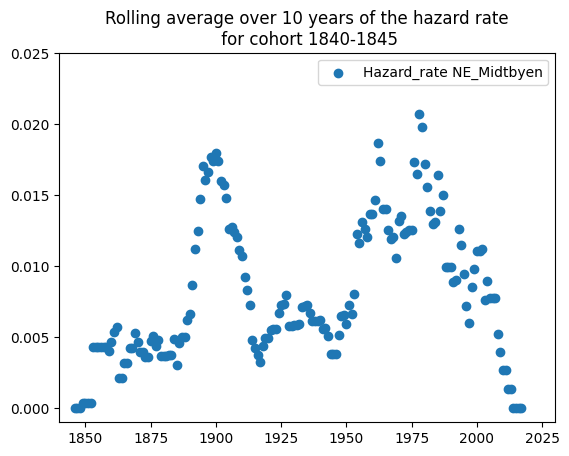

In [68]:
# plot rolling avg of the hr for the selected cohorts

plt.title('Rolling average over 10 years of the hazard rate\n for cohort 1840-1845')
len_ma = len(hazard_rate)
steps_ma = np.arange(0,len_ma)
plt.scatter(steps_ma+debut_date+n/2,hazard_rate) 
plt.xlim(1840,2030)
plt.ylim(-0.001,0.025)
labels=['Hazard_rate NE_Midtbyen']
plt.legend(labels=labels)

### With h(t) = L(t)/S(t)

#### Functions

In [69]:
# for each distribution

def hr_weibull(x,a,k):
    return lifetime_weibull(x,a,k)/weibull(x,a,k)

def hr_norm(x, loc, scale):
    return norm.pdf(x, loc, scale)/norm.sf(x,loc,scale)

def hr_lognorm(x, s, loc, scale):
    return lognorm.pdf(x, s, loc, scale)/lognorm.sf(x,s,loc,scale)

def hr_truncnorm(x,a,b,loc,scale):
    return truncnorm.pdf(x,a,b,loc,scale)/truncnorm.sf(x,a,b,loc,scale)

In [70]:
#hr for frankenstein
# Calculate the differences between consecutive survival probabilities
diff_survival_probabilities = np.diff(spline(x_range))

# Calculate the derivative of the lifetime distribution
lifetime_distribution_derivative = -diff_survival_probabilities / np.diff(x_range)

#plt.plot(x_range[:len(x_range)-1],lifetime_distribution_derivative)
#plt.xlim(0,2300)
#plt.ylim(0,0.007)

hr_frank = lifetime_distribution_derivative/spline(x_range[0:len(x_range)-1])


C:\Users\zoec\AppData\Local\Temp\ipykernel_19340\801739605.py:4: RuntimeWarning: invalid value encountered in divide
  return lifetime_weibull(x,a,k)/weibull(x,a,k)
C:\Users\zoec\AppData\Local\Temp\ipykernel_19340\801739605.py:7: RuntimeWarning: divide by zero encountered in divide
  return norm.pdf(x, loc, scale)/norm.sf(x,loc,scale)
C:\Users\zoec\AppData\Local\Temp\ipykernel_19340\801739605.py:7: RuntimeWarning: invalid value encountered in divide
  return norm.pdf(x, loc, scale)/norm.sf(x,loc,scale)
C:\Users\zoec\AppData\Local\Temp\ipykernel_19340\801739605.py:13: RuntimeWarning: invalid value encountered in divide
  return truncnorm.pdf(x,a,b,loc,scale)/truncnorm.sf(x,a,b,loc,scale)


R² weibull = 0.10698244276829294
R² normal = -0.675337419839763
R² lognormal = 0.2350381212247794


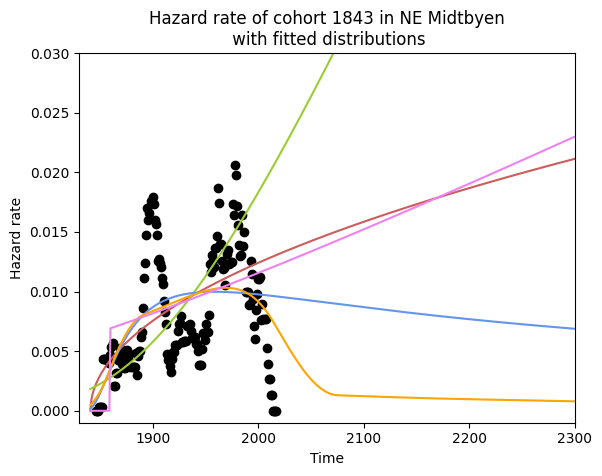

In [71]:
#plot it with the two different methods

plt.title('Hazard rate of cohort 1843 in NE Midtbyen\n with fitted distributions')

plt.plot(x_range + debut_date, hr_weibull(x_range, *p_weib), color='indianred')
plt.plot(x_range + debut_date  , hr_norm(x_range, *p_norm), color='yellowgreen')
plt.plot(x_range + debut_date  , hr_lognorm(x_range,*p_logn), color='cornflowerblue')
plt.plot(x_range[:len(x_range)-1] + debut_date  , hr_frank[:len(x_range)], color='orange')
plt.plot(x_range + debut_date, hr_truncnorm(x_range, *param_truncnorm), color='violet')
plt.scatter(steps_ma + debut_date+n/2,hazard_rate, color='k')

r_hr_weibull = calculate_r_squared(hazard_rate, hr_weibull(steps_ma, *p_weib))
r_hr_norm = calculate_r_squared(hazard_rate, hr_norm(steps_ma, *p_norm))
r_hr_lognorm = calculate_r_squared(hazard_rate, hr_lognorm(steps_ma, *p_logn))
#r_hr_frank = calculate_r_squared(hazard_rate,hr_frank[:len(steps_ma)])

plt.xlim(1830,2300)
plt.ylim(-0.001,0.03)
plt.xlabel('Time')
plt.ylabel('Hazard rate')

print("R² weibull =",r_hr_weibull)
print("R² normal =",r_hr_norm)
print("R² lognormal =",r_hr_lognorm)
#print("R² frank =",r_hr_frank)
#plt.legend(['Hazard rate calculated with weibull distribution','Hazard rate calculated with normal distribution','Hazard rate calculated with lognormal distribution', 'Hazard rate Frankenstein', 'Scattered data'],  loc = 'lower center', bbox_to_anchor=(0.5, -0.4))

## Monte Carlo simulation

### Code

In [73]:
# creating the Monte Carlo dataframe (a copy of the necessary parameters of the full df)
df_MC = df_full[['Construction_min','Construction_max','C_lognorm','Demolition_min','Demolition_max','D_unif', 'Is_demolished','Age_at_demolition']].copy()

# keeping only the buildings that can potentially be part of the study cohorts 
df_not_btw_1840_1845 = df_MC[(df_MC['Construction_max']< debut_date) | (df_MC['Construction_min']> end_date)]
df_MC = df_MC.drop(df_not_btw_1840_1845.index)

"""---------------------------------------------------------------------------------"""
x_range = np.linspace(0, 10000, 10001) 

# Set the number of iterations to perform
n_iterations = 10000

n_avg = 10 # for the rolling avrg

# Initialize arrays to store the survival curves for each iteration
hazard_rates = np.zeros((n_iterations, len(steps_ma)))

# Initialize arrays to store the survival curves for each iteration
survival_curves = np.zeros((n_iterations, len(age_steps) ))
len_selected_df = np.zeros((n_iterations, len(x_range) ))

# for each distribution
#normal
param_fitted_norm_sf = np.zeros((n_iterations, 2 ))
fitted_norm_sf = np.zeros((n_iterations, len(x_range) ))
#lognormal
param_fitted_lognorm_sf = np.zeros((n_iterations, 3 ))
fitted_lognorm_sf = np.zeros((n_iterations, len(x_range) ))
#weibull
param_fitted_weibull_sf = np.zeros((n_iterations, 2 ))
fitted_weibull_sf = np.zeros((n_iterations, len(x_range) ))
#truncnorm
param_fitted_truncnorm_sf = np.zeros((n_iterations, 4 ))
fitted_truncnorm_sf = np.zeros((n_iterations, len(x_range) ))

# Perform the Monte Carlo simulation
for i in range(n_iterations):

    # Attribute uniform construction dates to the survivor (still standing) buildings
    stding_df = attribute_c_unif(df_MC)

    # Fit a lognormal curve to the histogram of cohorts of the survivor buildings
    par_logn_stg = fit_cohort(stding_df)

    # attribute a construction date according to this lognormal distribution
    attribute_c_lognorm(df_MC,par_logn_stg)

    #attribute a demolition date randomly between D_min and D_max
    attribute_d_unif(df_MC)

    #select the cohorts of study debut -> end date
    df_selected_cohort = selected_cohorts(df_MC, debut_date, end_date)

    # assume that they were all built at the same time (1843)
    df_selected_cohort = df_selected_cohort.assign(C_lognorm = assumed_cohort)

    # make a df of demolished buildings that are part of the selected cohort
    dem_df = df_selected_cohort[(df_selected_cohort['Is_demolished'] == True)]

    # compute the failure time (age at demolition) of the buildings in the selected cohorts
    failure_time(dem_df,df_selected_cohort)
    len_selected_df[i,:] = len(df_selected_cohort)
    
    # Calculate the survival curve for this iteration and store it
    survival_curves[i, :] = survival_curve(age_steps, df_selected_cohort)
    
    # fit it with a normal distribution
    param_fitted_norm_sf[i,:] = fit_surv_fct(norm_sf, age_steps, survival_curves[i, :])
    fitted_norm_sf[i, :] =  norm_sf(x_range, *param_fitted_norm_sf[i,:])

    # fit it with a lognormal distribution
    param_fitted_lognorm_sf[i,:] = fit_surv_fct(lognorm_sf, age_steps, survival_curves[i, :])
    fitted_lognorm_sf[i, :] =  lognorm_sf(x_range, *param_fitted_lognorm_sf[i,:])

    # fit it with a weibull distribution
    param_fitted_weibull_sf[i,:] = fit_surv_fct(weibull, age_steps, survival_curves[i, :])
    fitted_weibull_sf[i, :] =  weibull(x_range, *param_fitted_weibull_sf[i,:])

    #fit it with truncnorm
    param_fitted_truncnorm_sf[i,:] ,trunc_cov= curve_fit(truncnorm_sf, age_steps, survival_curves[i, :],p0=p0)
    fitted_truncnorm_sf[i, :] =  truncnorm_sf(x_range, *param_fitted_truncnorm_sf[i,:])

    #hazard rate
    hazard_rates[i,:] = fct_hr_all(n,df_selected_cohort,age_steps)

C:\Users\zoec\AppData\Local\Temp\ipykernel_19340\3530553073.py:4: RuntimeWarning: divide by zero encountered in power
  return np.exp(-(x*a)**k)
C:\Users\zoec\AppData\Local\Temp\ipykernel_19340\3530553073.py:4: RuntimeWarning: invalid value encountered in power
  return np.exp(-(x*a)**k)
c:\Users\zoec\OneDrive - NTNU\Publication\code_building_lifetimes\.venv\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\zoec\AppData\Local\Temp\ipykernel_19340\3530553073.py:4: RuntimeWarning: divide by zero encountered in power
  return np.exp(-(x*a)**k)
C:\Users\zoec\AppData\Local\Temp\ipykernel_19340\3530553073.py:4: RuntimeWarning: invalid value encountered in power
  return np.exp(-(x*a)**k)
c:\Users\zoec\OneDrive - NTNU\Publication\code_building_lifetimes\.venv\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of

#### Survival function

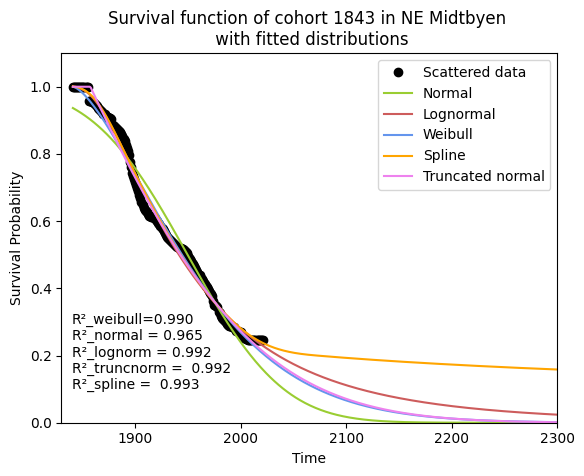

In [76]:
# Calculate the mean and standard deviation of the survival curves
mean_survival_curve = np.mean(survival_curves, axis=0)
std_survival_curve = np.std(survival_curves, axis=0)

# Plot the mean survival curve and its standard deviation
plt.plot(x+ debut_date, mean_survival_curve, 'ko', label='Scattered data')
#plt.fill_between(x + debut_date, mean_survival_curve - 2 * std_survival_curve,
#                 mean_survival_curve + 2 * std_survival_curve, alpha=0.2, color='black', label='95% CI')

# Calculate the mean and standard deviation of the survival curves
mean_param_norm_sf = np.mean(param_fitted_norm_sf, axis=0)
std_norm_sf = np.std(fitted_norm_sf, axis=0)

mean_param_lognorm_sf = np.mean(param_fitted_lognorm_sf, axis=0)
std_lognorm_sf = np.std(fitted_lognorm_sf, axis=0)

mean_param_weibull_sf = np.mean(param_fitted_weibull_sf, axis=0)
std_weibull_sf = np.std(fitted_weibull_sf, axis=0)

mean_param_truncnorm_sf = np.mean(param_fitted_truncnorm_sf, axis=0)
std_truncnorm_sf = np.std(fitted_truncnorm_sf, axis=0)

# Plot the mean survival curve and its standard deviation
plt.plot(x_range + debut_date, norm_sf(x_range,*mean_param_norm_sf), color='yellowgreen', label='Normal')
plt.plot(x_range + debut_date, lognorm_sf(x_range,*mean_param_lognorm_sf), color='indianred', label='Lognormal')
plt.plot(x_range + debut_date, weibull(x_range,*mean_param_weibull_sf), color='cornflowerblue', label='Weibull')
plt.plot(x_range+debut_date, spline(x_range),'orange',label='Spline')
plt.plot(x_range+debut_date,truncnorm_sf(x_range,*mean_param_truncnorm_sf),color='violet',label='Truncated normal')
#plt.fill_between(x_range + debut_date, mean_survival_curve - 2 * std_survival_curve,
#                 mean_survival_curve + 2 * std_survival_curve, alpha=0.2, color='blue', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival function of cohort 1843 in NE Midtbyen \n with fitted distributions')
plt.legend()
plt.ylim(0,1.1)
plt.xlim(1830,2300)

r_lognorm = calculate_r_squared(y,lognorm_sf(x,*mean_param_lognorm_sf))
r_norm = calculate_r_squared(y,norm_sf(x,*mean_param_norm_sf))
r_weibull = calculate_r_squared(y,weibull(x,*mean_param_weibull_sf))
r_truncnorm = calculate_r_squared(y,truncnorm_sf(x,*mean_param_truncnorm_sf))

plt.annotate('R²_weibull=%.3f\nR²_normal = %.3f\nR²_lognorm = %.3f\nR²_truncnorm =  %.3f\nR²_spline =  %.3f' %(r_weibull,r_norm,r_lognorm,r_truncnorm,r_frank), (1840, 0.1))

plt.show()

In [85]:
mean_param_norm_sf = np.mean(param_fitted_norm_sf, axis=0)
mean_param_norm_sf_1 = np.append(mean_param_norm_sf, [0, 0])
print(mean_param_norm_sf)

mean_param_lognorm_sf = np.mean(param_fitted_lognorm_sf, axis=0)
mean_param_lognorm_sf_1 = np.append(mean_param_lognorm_sf, 0)
print(mean_param_lognorm_sf)

mean_param_weibull_sf = np.mean(param_fitted_weibull_sf, axis=0)
mean_param_weibull_sf_1 = np.append(mean_param_weibull_sf, [0, 0])
print(mean_param_weibull_sf)

mean_param_truncnorm_sf = np.mean(param_fitted_truncnorm_sf, axis=0)
print(mean_param_truncnorm_sf)


[108.63495294  71.15577799]
[  0.73111698  -9.94505181 110.41373134]
[0.00755895 1.48613025]
[  0.33401079 141.28571429 -33.85194188 150.99176445]


In [83]:
# compute the lifetime from the survival function (using the tail formula)

def get_average_lifetime(fitted_sf):
    n_iter = len(fitted_sf)
    lifetime_values = np.zeros(n_iter)
    for i in range(n_iter):
        integrand = fitted_sf[i, :]  # Use the survival curve for each iteration: IT HAS TO REACH ZERO
        lifetime_values[i] = integrate.trapz(integrand, x_range)
    # Compute the mean, std deviation and confidence interval of the lifetime
    mean_lifetime_distrib= np.mean(lifetime_values)
    std_lifetime = np.std(lifetime_values)
    confidence_interval_lifetime = np.percentile(lifetime_values, [2.5, 97.5])
    #print the results
    print("Average Lifetime:", mean_lifetime_distrib)
    print("Standard Deviation:", std_lifetime)
    print("Confidence Interval (95%):", confidence_interval_lifetime)
    return [mean_lifetime_distrib,std_lifetime,confidence_interval_lifetime]

get_average_lifetime(fitted_truncnorm_sf)

Average Lifetime: 120.99531603653752
Standard Deviation: 0.4785823130066756
Confidence Interval (95%): [120.13774546 121.98958864]


[120.99531603653752, 0.4785823130066756, array([120.13774546, 121.98958864])]

In [81]:
# Create a DataFrame
"""df = pd.DataFrame({
    'Mean_Param_Norm_SF': mean_param_norm_sf,
    'Mean_Param_LogNorm_SF': mean_param_lognorm_sf,
    'Mean_Param_Weibull_SF': mean_param_weibull_sf,
    'Mean_Param_Truncnorm_SF': mean_param_truncnorm_sf
})

# Export to Excel
df.to_excel('mean_parameters.xlsx',sheet_name='NE Midtbyen' ,index=False)"""

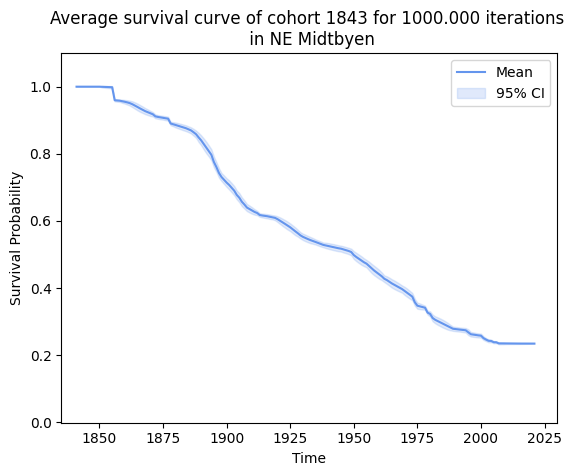

In [ ]:
# Calculate the mean and standard deviation of the survival curves
mean_survival_curve = np.mean(survival_curves, axis=0)
std_survival_curve = np.std(survival_curves, axis=0)

# Plot the mean survival curve and its standard deviation
plt.plot(x+ debut_date, mean_survival_curve, color='cornflowerblue', label='Mean')
plt.fill_between(x + debut_date, mean_survival_curve - 2 * std_survival_curve,
                 mean_survival_curve + 2 * std_survival_curve, alpha=0.2, color='cornflowerblue', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Average survival curve of cohort 1843 for %.3f iterations \n in NE Midtbyen' %(n_iterations))
plt.legend()
plt.ylim(0,1.1)

plt.xlim(1835,2030)
plt.ylim(-0.001,1.1)


plt.show()
# for cohorts 1841-1845 = estimated as cohort 1843
  

#### Lifetime distribution

In [103]:
# compute the lifetime from the survival function (using the tail formula)
lifetime_values = np.zeros(n_iterations)

for i in range(n_iterations):
    integrand = fitted_norm_sf[i, :]  # Use the survival curve for each iteration: IT HAS TO REACH ZERO
    lifetime_values[i] = integrate.trapz(integrand, x_range)

# Compute the mean, std deviation and confidence interval of the lifetime
mean_lifetime_distrib= np.mean(lifetime_values)
std_lifetime = np.std(lifetime_values)
confidence_interval_lifetime = np.percentile(lifetime_values, [2.5, 97.5])

# print the results
print("Average Lifetime:", mean_lifetime_distrib)
print("Standard Deviation:", std_lifetime)
print("Confidence Interval (95%):", confidence_interval_lifetime)
print(fitted_weibull_sf[1])

Average Lifetime: 114.6364555990705
Standard Deviation: 0.29062508894839506
Confidence Interval (95%): [114.09074275 115.22030258]
[1.00000000e+000 9.99464557e-001 9.98453492e-001 ... 6.27335661e-310
 5.62538411e-310 5.04431124e-310]


#### Hazard rate

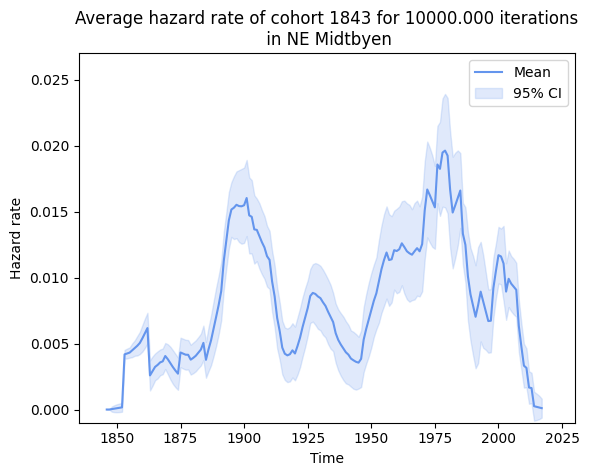

In [82]:
# Calculate the mean and standard deviation of the survival curves
mean_hr = np.mean(hazard_rates, axis=0)
std_hr= np.std(hazard_rates, axis=0)

# Plot the mean survival curve and its standard deviation
plt.plot(steps_ma + debut_date+n/2, mean_hr, color='cornflowerblue', label='Mean')
plt.fill_between(steps_ma+ debut_date+n/2, mean_hr - 2 * std_hr,
                 mean_hr + 2 * std_hr, alpha=0.2, color='cornflowerblue', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Hazard rate')
plt.title('Average hazard rate of cohort 1843 for %.3f iterations\n in NE Midtbyen' %(n_iterations))
plt.legend()

plt.xlim(1835,2030)
plt.ylim(-0.001,0.027)
plt.show()

C:\Users\zoec\AppData\Local\Temp\ipykernel_19340\801739605.py:7: RuntimeWarning: divide by zero encountered in divide
  return norm.pdf(x, loc, scale)/norm.sf(x,loc,scale)
C:\Users\zoec\AppData\Local\Temp\ipykernel_19340\801739605.py:7: RuntimeWarning: invalid value encountered in divide
  return norm.pdf(x, loc, scale)/norm.sf(x,loc,scale)
C:\Users\zoec\AppData\Local\Temp\ipykernel_19340\801739605.py:13: RuntimeWarning: invalid value encountered in divide
  return truncnorm.pdf(x,a,b,loc,scale)/truncnorm.sf(x,a,b,loc,scale)


R² weibull = 0.10698244276829294
R² normal = -0.675337419839763
R² lognormal = 0.2350381212247794


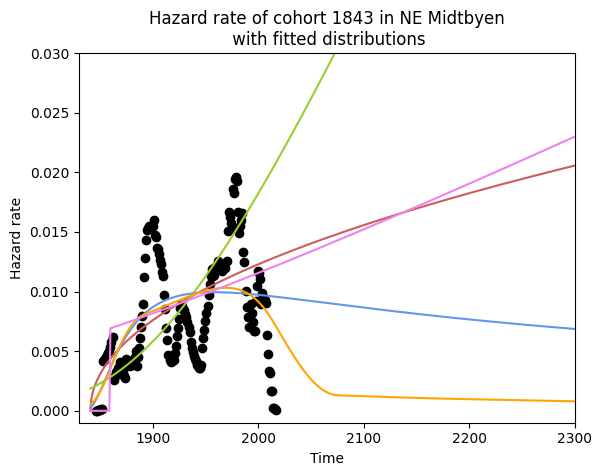

In [88]:
#plot it with the two different methods

plt.title('Hazard rate of cohort 1843 in NE Midtbyen\n with fitted distributions')

plt.plot(x_range + debut_date, hr_weibull(x_range, *mean_param_weibull_sf), color='indianred')
plt.plot(x_range + debut_date  , hr_norm(x_range, *mean_param_norm_sf), color='yellowgreen')
plt.plot(x_range + debut_date  , hr_lognorm(x_range,*mean_param_lognorm_sf), color='cornflowerblue')
plt.plot(x_range[:len(x_range)-1] + debut_date  , hr_frank[:len(x_range)-1], color='orange')
plt.plot(x_range + debut_date, hr_truncnorm(x_range, *param_truncnorm), color='violet')
plt.scatter(steps_ma + debut_date+n/2,mean_hr, color='k')

r_hr_weibull = calculate_r_squared(hazard_rate, hr_weibull(steps_ma, *p_weib))
r_hr_norm = calculate_r_squared(hazard_rate, hr_norm(steps_ma, *p_norm))
r_hr_lognorm = calculate_r_squared(hazard_rate, hr_lognorm(steps_ma, *p_logn))
#r_hr_frank = calculate_r_squared(hazard_rate,hr_frank[:len(steps_ma)])

plt.xlim(1830,2300)
plt.ylim(-0.001,0.03)
plt.xlabel('Time')
plt.ylabel('Hazard rate')

print("R² weibull =",r_hr_weibull)
print("R² normal =",r_hr_norm)
print("R² lognormal =",r_hr_lognorm)